In [27]:
import numpy as np
from numba import njit
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt


In [28]:
import pymc3 as pm

def _model(theta, x):
    return np.sin(theta[0] * x + theta[1]) * np.exp(-theta[2] * x)

In [41]:
def _lstsq_D(C, D):
    """Calculates residuals efficiently  by (I - CC+)D.
    Projector CC+ is calculated by SVD: CC+ = U @ U.T.

    Removal of the columns of U that does not correspond to data is needed
    (those columns whose corresponding singular values ar    e
    lower
    than
    tolerance)"""

    U, S, VT = np.linalg.svd(C, full_matrices=False)

    Sr = S[S > S[0] * 1e-10]
    Ur = U[:, :Sr.shape[0]]

    CC_plus_D = Ur.dot(Ur.T).dot(D)

    return CC_plus_D

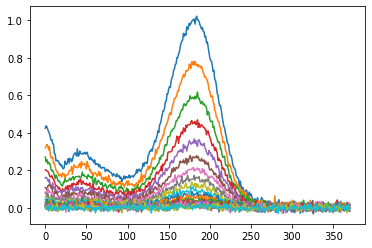

In [46]:
eps = np.loadtxt(r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup\spectra_fit.csv',
                 delimiter=',', skiprows=1)
ST = eps[:, 1].T  # ST is a matrix of n x w
ST /= ST.max()

wls = eps[:, 0]
N = 20
times = np.linspace(0, 100, N)
k = 0.05

C = np.exp(-k * times[:, None])
D = C @ ST[None, :]

D = np.random.normal(D, 0.01)


plt.plot(wls, D.T)
plt.show()

# plt.plot(times, C)
# plt.show()




# theta = np.asarray([1.5, 0.5, 0.1])
# N = 200

# # np.random.seed(10)
# x =  np.random.rand(N) * 20
# x = np.sort(x)
# y = _model(theta, x)

# # x = np.random.normal(x, 5)
# y = np.random.normal(y, 0.3)

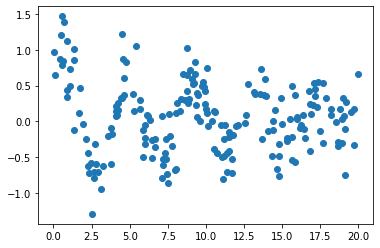

In [4]:
plt.plot(x, y, 'o')

In [51]:

with pm.Model() as model:
    
    # Define priors
    sigma = pm.HalfNormal("sigma", sd=2)
    
#     theta = Normal('beta', mu=0, sd=10, shape=2)
    
    _k = pm.Normal('_k', mu=0.05, sd=3)
#     a1 = pm.Normal('a1', mu=0.5, sd=1)
#     a2 = pm.Normal('a2', mu=0.1, sd=1)
#     a3 = pm.Normal('a3', mu=1, sd=10)

    C = np.exp(-_k * times[:, None])
    
#     D_simul = 

    # Define likelihood
    likelihood = pm.Normal('y', mu=_lstsq_D(C, D) , sd=sigma, observed=D)

    # Inference!
    trace = pm.sample(2000, cores=2) # draw 3000 posterior samples using NUTS sampling

_k


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FEE7DC6A0>,
      dtype=object)

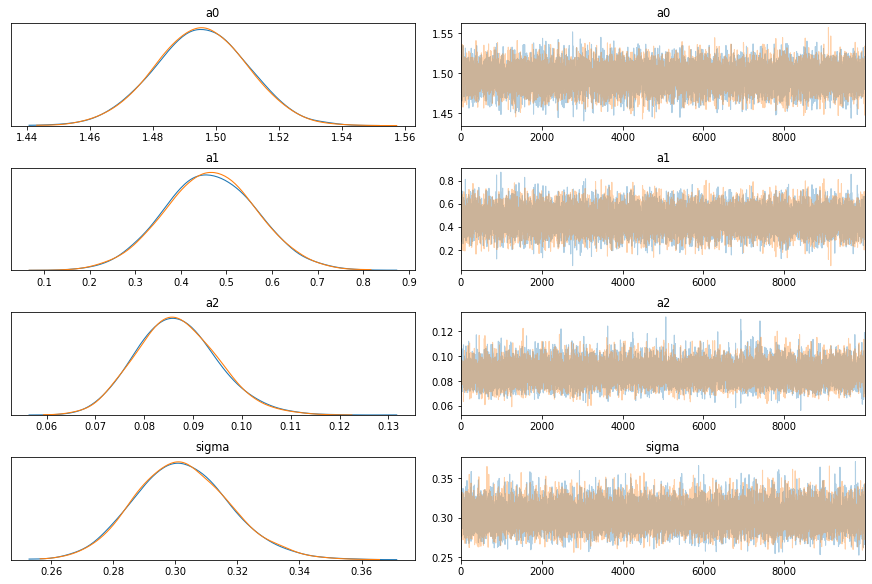

In [6]:
pm.traceplot(trace[:])

In [69]:
trace["a0"].shape

(20000,)

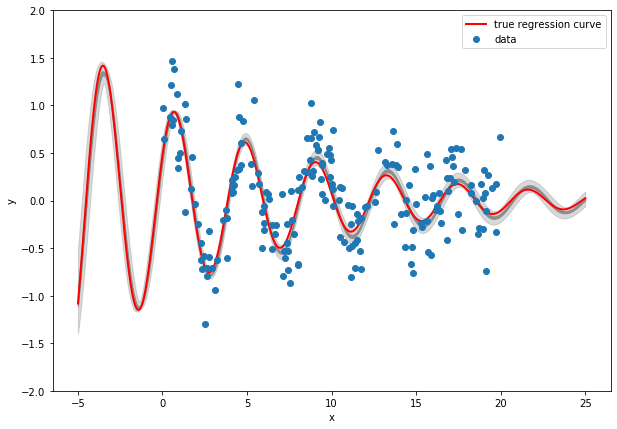

In [7]:
plt.figure(figsize=(10, 7))


# slope_samples = trace[100:]['slope']
# int_samples = trace[100:]['intercept']


a0_samples = trace[100:]['a0']
a1_samples = trace[100:]['a1']
a2_samples = trace[100:]['a2']
#a3_samples = trace[100:]['a3']


_x = np.linspace(-5, 25, 500)

# curves = a0_samples[:, None] + a1_samples[:, None] * _x[None, :] + a2_samples[:, None] * _x[None, :] ** 2#  + a3_samples[:, None] * _x[None, :] ** 3

curves = _model([a0_samples[:, None], a1_samples[:, None], a2_samples[:, None]], _x[None, :])


# lines = slope_samples[:, None] * _x[None, :] + int_samples[:, None]

# plt.plot(x, lines[::100].T, lw=0.1, color='gray')

true_y = _model(theta, _x)
plt.plot(_x, true_y, label='true regression curve', lw=2., c='r')

q_1, q_32, q_68, q_99 = np.quantile(curves, [0.01, 0.32, 0.68, 0.99], axis=0)


# slope_avrg = slope_samples.mean()
# int_avrg = int_samples.mean()
# line_avrg = slope_avrg  * _x + int_avrg

plt.fill_between(_x, q_32, q_68, color=(0.5, 0.5, 0.5, 0.8))
plt.fill_between(_x, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

# plt.fill_between(_x, true_y + 2 * stds, true_y - 2 * stds, color=(0.5, 0.5, 0.5, 0.5))
# plt.fill_between(_x, true_y + 3 * stds, true_y - 3 * stds, color=(0.5, 0.5, 0.5, 0.3))

# plt.plot(_x, _model([a0_samples.mean(), a1_samples.mean(), a2_samples.mean()], _x), label='fit', lw=2., c='b')

plt.plot(x, y, 'o', label='data')



# plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)


plt.show()


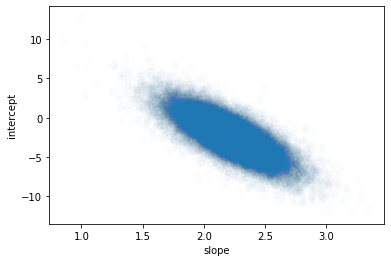

In [9]:
plt.plot(slope_samples[::1], int_samples[::1], 'o', alpha=0.01)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.show()

In [86]:
samples = poisson_param.random(size=500000)

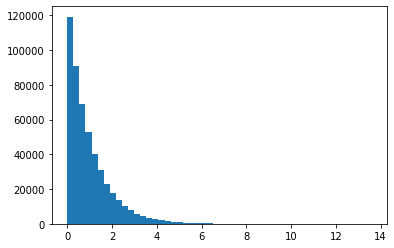

In [90]:
res = plt.hist(samples, bins=50, histtype="stepfilled")

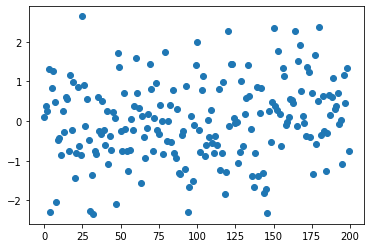

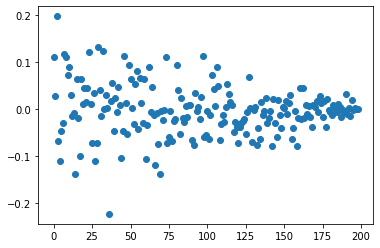

In [37]:
x = np.random.normal(0, 1, size=200)

corr =np.correlate(x, x, mode='full')
corr /= corr.max()
corr = corr[corr.size // 2 + 1:]

plt.plot(x, 'o')
plt.show()
plt.plot(corr, 'o')